[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/interpretable_ml.ipynb) 


# BADS - Interpretable Machine Learning

In [1]:
# Import standard packages. We import specific packages later when we first need them.
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Create a global variable to idicate whether the notebook is run in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules


# Configure variables pointing to directories and stored files 
if IN_COLAB:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/My Drive/data/'  # adjust to Google drive folder with the data if applicable
else:
    DATA_DIR = '../data/' # adjust to the directory where data is stored on your machine (if running the notebook locally)


<a id="ch1"></a>

## 1. Data integration
Details on getting and loading the data were covered in the data preparation notebook.

In [ ]:
# Load data
hmeq = pd.read_csv('./hmeq_modeling.csv') # make sure you use the right path

# The following operations are detaild in the notebook P.I.1
hmeq['BAD'] = hmeq['BAD'].astype('bool')
hmeq['LOAN'] = hmeq['LOAN'].astype(np.float64)
# Code categories properly 
hmeq['REASON'] = hmeq['REASON'].astype('category')
hmeq['JOB'] = hmeq['JOB'].astype('category')
hmeq['DELINQcat'] = hmeq['DELINQcat'].astype('category')

hmeq.drop(['DELINQ', 'DEROG'], axis=1, inplace=True)  # we drop these columns because we can use the discretized versions
hmeq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BAD        5960 non-null   bool    
 1   LOAN       5960 non-null   float64 
 2   MORTDUE    5960 non-null   float64 
 3   VALUE      5960 non-null   float64 
 4   REASON     5960 non-null   category
 5   JOB        5960 non-null   category
 6   YOJ        5960 non-null   float64 
 7   CLAGE      5960 non-null   float64 
 8   NINQ       5960 non-null   float64 
 9   CLNO       5960 non-null   float64 
 10  DEBTINC    5960 non-null   float64 
 11  DELINQcat  5960 non-null   category
 12  DEROGzero  5960 non-null   bool    
dtypes: bool(2), category(3), float64(8)
memory usage: 402.1 KB


In [ ]:
hmeq.REASON.value_counts()

DebtCon      3928
HomeImp      1780
IsMissing     252
Name: REASON, dtype: int64

### Categorical variables
Our data frame includes three categorical variables. Some learning algorithms will be able to process categorical data natively. Many others, however, are not able to do so. Therefore, it is common practice to encode or recode categories before they go into a model. The standard way to do so is dummy coding. A dummy variable is a binary vector that codes the values of one category level. For example, a vector for the variable 'JOB' and category level 'Office'. In this vector the value would be 1 for every observation with an office job, and 0 for all others. 

To understand why we need to use dummy coding, consider the example of logistic regression. Regression analysis is common practice for using a continuous variable (e.g. 'LOAN') to predict the independent variable ('BAD' in this example). As you cannot rank and/or calculate a meaningful distance between categories, this interpretation is not possible. However, if we split up these variable into the earlier described dummy variables, we create a numeric variable by only using the number 0 and 1. The new variables will then be used as input for the categorical variable. In our case, we would have 6 different dummy variables for the variable 'JOB' as it had 6 categories. 

However, regression settings also have problems with multicollinearity. This means that if we incorporate all six new dummy variables, we will encounter a problem. If we would, the sum of the 6 vectors would result in the value 1 for every observation. If this is too abstract for you, let's look at this by using an example. One observation's (all other variables excluded) dummy variables for the category 'JOB'.

|  JOB_Mgr 	| JOB_Office  	| JOB_Other  	| JOB_ProfExe  	| JOB_Sales  	| JOB_Self  	|
|---	|---	|---	|---	|---	|---	|
|   0	|   0	|   0	|   0	|   0	|   1	|
 
    
However, the value 0 for all other categories ('Mgr', 'Office', 'Other', 'ProxExe' and 'Sales') already indicates that the job must be the category 'Self'. Therefore, one dummy is redundant. And that is what multicollinearity is about. Multicollinearity is the high correlations among independent variables in a regression setting. Therefore, we can escape the so called dummy trap by dropping one dummy variable for each category. 

In [ ]:
# Dummy coding is easy to implement using Pandas or scikit-learn functions.
# We use the Pandas implementation. Make sure to take a look at the documentation. 
# The function is quite powerful. 
cat_vars = hmeq.select_dtypes(include='category').columns

hmeq = pd.get_dummies(hmeq, prefix_sep="_", columns=cat_vars, drop_first=True)

# Note the new dummy columns and their naming
hmeq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BAD               5960 non-null   bool   
 1   LOAN              5960 non-null   float64
 2   MORTDUE           5960 non-null   float64
 3   VALUE             5960 non-null   float64
 4   YOJ               5960 non-null   float64
 5   CLAGE             5960 non-null   float64
 6   NINQ              5960 non-null   float64
 7   CLNO              5960 non-null   float64
 8   DEBTINC           5960 non-null   float64
 9   DEROGzero         5960 non-null   bool   
 10  REASON_HomeImp    5960 non-null   uint8  
 11  REASON_IsMissing  5960 non-null   uint8  
 12  JOB_Office        5960 non-null   uint8  
 13  JOB_Other         5960 non-null   uint8  
 14  JOB_ProfExe       5960 non-null   uint8  
 15  JOB_Sales         5960 non-null   uint8  
 16  JOB_Self          5960 non-null   uint8  


In [ ]:
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
0,True,1100.0,25860.0,39025.0,10.5,94.366670,1.0,9.0,34.81826,True,1,0,0,1,0,0,0,0,0
1,True,1300.0,70053.0,68400.0,7.0,121.833336,0.0,14.0,34.81826,True,1,0,0,1,0,0,0,0,1
2,True,1500.0,13500.0,16700.0,4.0,149.466660,1.0,10.0,34.81826,True,1,0,0,1,0,0,0,0,0
3,True,1500.0,65019.0,89235.5,7.0,173.466660,1.0,20.0,34.81826,True,0,1,0,1,0,0,0,0,0
4,False,1700.0,97800.0,112000.0,3.0,93.333336,0.0,14.0,34.81826,True,1,0,1,0,0,0,0,0,0


In [ ]:
hmeq.YOJ.hist()

count    5960.000000
mean        8.645109
std         6.953265
min         0.000000
25%         3.000000
50%         7.000000
75%        12.000000
max        25.500000
Name: YOJ, dtype: float64

### Numeric variables
Remember that we have already performed many of the preparatory steps for numeric variables including imputing missing values and handling outliers. Below we will scale the variables. This is to ensure that the numeric variables share a common number range. Many  learner algorithms are robust toward different number ranges. Whether scaling is essential or not depends on the algorithm. However, you can also consider it good practice as it may help interpreting a model in a later step. We use functionality of the scikit-learn library to scale numeric variables so that their value ranges are easier to compare.scikit-learn features multiple classes for different types of scaling. Their use is always the same and consistent with our example. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # this class standardizes the data

X = hmeq.select_dtypes(include='float64')  # extract numeric variables
X_new = scaler.fit_transform(X)  # perform the scaling
X_new = pd.DataFrame(X_new, columns = X.columns)  # convert result into a data frame
hmeq[X.columns] = X_new

hmeq.head(10)

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0
5,True,-1.767431,-1.159844,-1.306305,0.051044,-0.984248,-0.065054,-1.405650,0.523025,True,1,0,0,1,0,0,0,0,0
6,True,-1.756622,-0.634583,-0.929097,-0.524274,-1.296677,-0.065054,-0.432087,0.137456,True,1,0,0,1,0,0,0,0,1
7,True,-1.756622,-1.219216,-1.245066,0.338703,-1.147091,-0.826792,-1.405650,0.484606,True,1,0,0,1,0,0,0,0,0
8,True,-1.735005,-1.097397,-1.161442,-0.811933,0.496310,-0.065054,-0.972955,0.137456,True,1,0,0,1,0,0,0,0,1
9,True,-1.735005,-0.159552,-0.811469,1.057849,-0.800453,-0.826792,-0.864781,0.137456,True,1,0,0,0,0,1,0,0,0


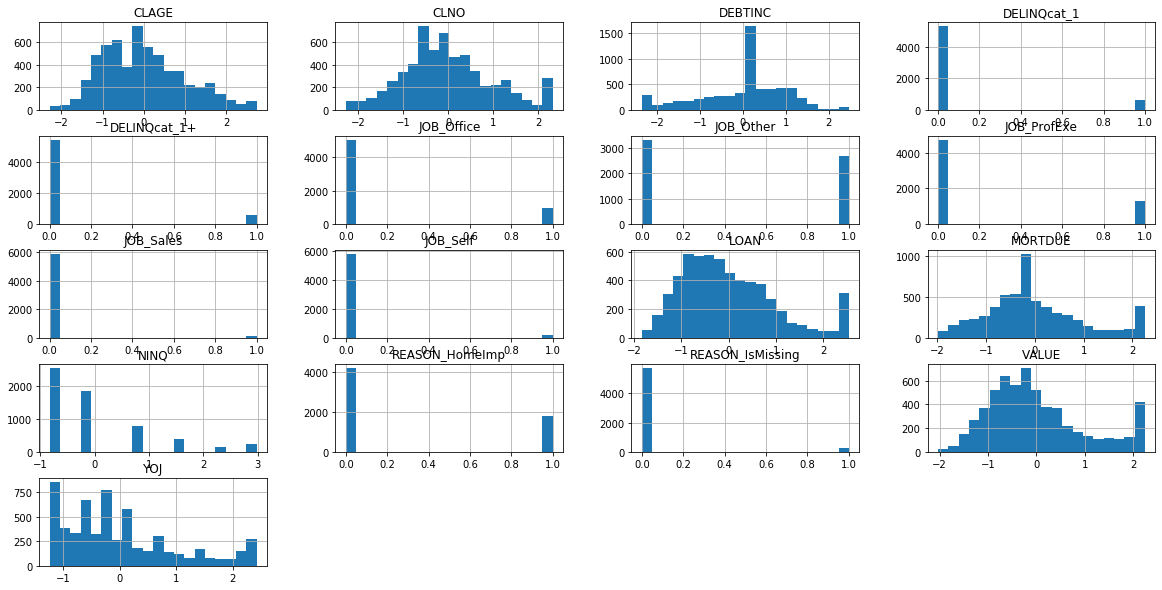

In [ ]:
# Verify that our data set looks fine
plt.rcParams["figure.figsize"] = (20,10)
hmeq.select_dtypes(exclude='bool').hist(bins=20);

Judging by the above chart, we could easily spot a couple of remaining issue and continue with improve the quality of our data. But let's leave it for now and start with the actual modeling. Since we won't change the data anymore, it is a good time to create a backup.

In [ ]:
# Save data
hmeq.to_csv('hmeq_modeling.csv')

Many relevant modeling functions expect an input in the form $(y, X)$, where $y$ denotes the target variable and $X$ the covariates. We build these items from our prepared data frame and use them in the reminder.

In [ ]:
y = np.asarray(hmeq.BAD)
X = hmeq.copy()
X.drop('BAD', axis=1, inplace=True)

<a id="ch2"></a>

<a id="ch3"></a>

## 3. Evaluating predictive performance (resampling, confusion matrix, ROC)
Performance evaluation involves practices to simulate an application of a model and accuracy indicators to capture how well it predicts. 

We build a model on our data. But how do we ensure, that our model finds generalizable patterns in the data as opposed to just describing this particular sample. 

### Data organization
The easiest approach is to build a model on the whole data set. This is what we did above. We could use the same data to make predictions and assess their accuracy. Remember that we called this approach a **resubstitution estimate** in lecture L.I.3. The resubstitution estimate  would overestimate model performance. To do better, we split the data into a training and a test set. This means, we train a model on a random subset of our data set, the training set. Then we use the remaining instances, the test set, also called hold out data, for model assessment. In order to evaluate the performance, we compute predictions of the test set with the model built on the training set. We compare these predictions to the actuals in the test set. Let's see how scikit-learn supports this workflow.

In [ ]:
# Data partitioning
from sklearn.model_selection import train_test_split

# create training and test set
# x_train = all columns but 'BAD' of training set (needed to build supervised learning model)
# y_train = outcome variable of training observations (needed to build supervised learning model)
# x_test = all columns but 'BAD' of test set (needed to predict outcome of test set with training set model)
# y_test = outcome variable of test observations (needed for model assessment)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )  # 20% of the data as hold-out

#make yourself familiar with these vectors
y_train.shape, x_train.shape, y_test.shape, x_test.shape

((4768,), (4768, 18), (1192,), (1192, 18))

We will now re-estimate the logit model. However, we use the scikit-learn version this time (for illustration) and make sure to not touch the test set. 

In [ ]:
from sklearn.linear_model import LogisticRegression

sk_logit = LogisticRegression(penalty='none', fit_intercept=True, max_iter=500)
log = sk_logit.fit(x_train, y_train)
print(log)

# Calculate classification accuracy on the training and the test set
print('Accuracy on train data: {:.4f}'.format(sk_logit.score(x_train, y_train)))
print('Accuracy on test data: {:.4f}'.format(sk_logit.score(x_test, y_test)));

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy on train data: 0.8251
Accuracy on test data: 0.8230


In [ ]:
100*sum(y_test==False)/len(y_test)

80.28523489932886

### Performance assessment
Accuracy indicators help us evaluate how well our model predicts the target. We compute them by comparing actuals to  predictions. This is also what the function *.score* has done in the above print statement. 

#### Classification accuracy and its shortcomings
Classification accuracy is a threshold metric. It calculates model performance for one threshold or classification cut-off. If not specified, this threshold is usually set to 0.5. Changing the threshold can change the accuracy a lot although the model stays the same. This is particularly true in imbalanced data sets like this one. Let me give you an exemplary scenario: We have 100 observations. 5 observations are of the class 'BAD' and 95 of the class 'GOOD'. So even without finding any generalizable patterns, classifying all observations as good would still result in an accuracy of 95%. To ensure robustness of our model, we want to avoid this. 

In our case, the accuracy is just under the accuracy of the training data. We've included both for comparison and as it can be a first indicator for overfitting (high score on training data, low on test). In our case however, it looks acceptable, which makes sense because logit is not prone to overfitting.

A preferable approach to assess classification performance is to consider all possible thresholds. This is what receiver-operating-characteristics (ROC) analysis does. Before looking into ROC, let's have a look at the full confusion table first, which will also remind us of the role of the threshold.

#### Confusion matrix

In [ ]:
from sklearn import metrics  # Important lib where we find various performance measures

# 1. Quick and dirty way to get a confusion table
cmat = metrics.confusion_matrix(y_test, sk_logit.predict(x_test))
print(cmat)

[[909  48]
 [163  72]]


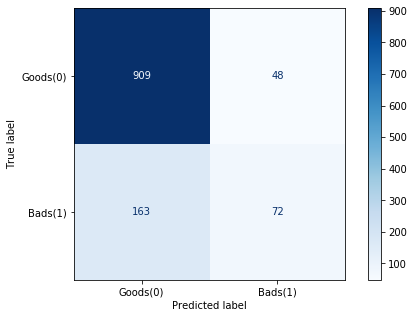

In [ ]:
# 2. Pretty-print confusion matrix
plt.rcParams["figure.figsize"] = (8,5)
metrics.plot_confusion_matrix(sk_logit, x_test, y_test, labels=[0, 1], display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Classification accuracy simply calculates the number of correct class predictions (main diagonal) over all cases. Here, what class a model predicts depends on the classification threshold. You classify cases as BAD if $p(y=BAD|x) \gt \tau$, where $\tau$ denotes the threshold. 

Hence, the above confusion table is based on one threshold, and might look rather different for another. A ROC curve considers all cut-offs $\tau \in [0,1]$ plotting the True Positive Rate and False Positive Rate for each threshold. 

#### ROC Curve and AUC

This is one of the most important evaluation metrics in classification analysis. Have a look at the graph below. The curve tells us how well the model differentiates the two classes, in regards to their predicted probabilities.
A ROC curve has the FPR on the X-axis and FPR on the Y-axis.
The curve is made up out of all the different combinations of TPR and FPR across all thresholds.

The AUC stand for the Area under the Curve and is a ranking indicator. The AUC estimates the probability that a randomly chosen positive instance is correctly ranked higher than a randomly chosen negative (Hanley and McNeil, 1983) . We calculate this area, as our goal is to have a FPR of 0 and a TPR of 1. This would be the perfect model. This point is in the top right corner of a ROC Curve. So the closer we get to that point, the better the model and the bigger the area under it. It is common practice to add a horizontal line to the plot. You can show that this line corresponds to a random classifier. So any serious model should give a ROC curve (much) above the horizontal line. This also implies that a classifier should display AUC (much) bigger than 0.5.


Below we show different way to plot the ROC curve.

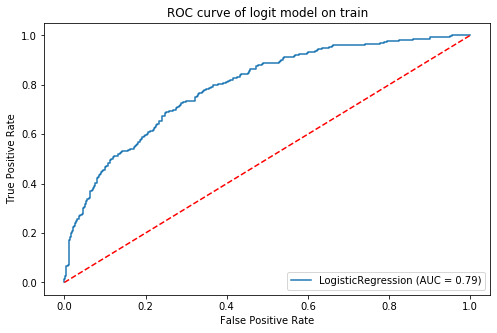

In [ ]:
# Scikit-learn offers an easy-to-use function to produce a ROC curve. 
metrics.plot_roc_curve(log, x_test, y_test)
plt.title('ROC curve of logit model on train')
plt.plot([0, 1], [0, 1], "r--");  # the random benchmark we need to add manually

If you want a little more control, for example to depict the training and test set results in one chart, you can proceed as follows: 

In [ ]:
# Example how to 'manually' plot the ROC curve
yhat_logit = log.predict_proba(x_test)[:, 1]

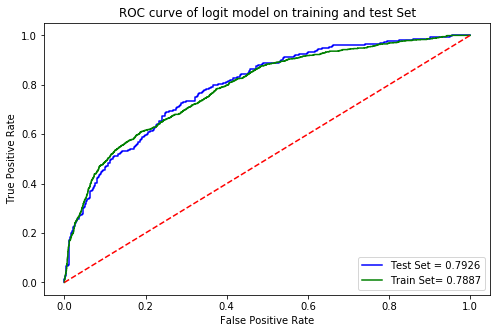

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, yhat_logit)  # extracting FPR and TPR for the test set
fpr_tr, tpr_tr, _ = metrics.roc_curve(y_train, log.predict_proba(x_train)[:, 1])  # same for the training set

# Compute AUC
auc = metrics.auc(fpr, tpr) 
auc_tr = metrics.auc(fpr_tr, tpr_tr)

# ROC curve:
# Test data
plt.plot(fpr, tpr, "b", label="Test Set = %0.4f" % auc)
# Training data
plt.plot(fpr_tr, tpr_tr, "b", label="Train Set= %0.4f" % auc_tr, color='green')
# Random benchmark
plt.legend(loc="lower right")
# Plot configuration
plt.title('ROC curve of logit model on training and test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.plot([0, 1], [0, 1], "r--");  # the random benchmark we need to add manually
plt.show()

In [ ]:
# Since we are about to compute many models, let's keep track of auc results using a dictionary
auc_trace = {'logit':auc}
auc_trace

{'logit': 0.792583205495898}

### Cross-validation (model simulation)

Cross validation is an extended approach of the split sample method. It consists of repeating the split sample method multiple times.

Step by step:
- Randomly split data in N disjoint folds (E.g., N=5) 
- Build model on N-1 folds and validate that model on the remaining fold 
- Apply trained model to predict cases in the validation sample (hold-out data) 
- Measure model performance 
- Repeat N times and average 
- Average model performance over validation folds gives performance estimate 
- Can also estimate standard deviation (e.g., for statistical hypothesis testing)

The following example is rather detailed and meant to show you the intermediate steps in a cross-validation process. Later, we will simplify cross-validation using convenience functions of scikit-learn.

Cross-validating the logit model:
	CV iter: 0 with AUC=0.7767912196325071
Average AUC on test set during cross-validation: 0.7768
	CV iter: 1 with AUC=0.7719288973451016
Average AUC on test set during cross-validation: 0.7744
	CV iter: 2 with AUC=0.7543117876081251
Average AUC on test set during cross-validation: 0.7677
	CV iter: 3 with AUC=0.7867096524144249
Average AUC on test set during cross-validation: 0.7724
	CV iter: 4 with AUC=0.7855469231717844
Average AUC on test set during cross-validation: 0.7751
	CV iter: 5 with AUC=0.7816887761393865
Average AUC on test set during cross-validation: 0.7762
	CV iter: 6 with AUC=0.7800856191533218
Average AUC on test set during cross-validation: 0.7767
	CV iter: 7 with AUC=0.8265771717492028
Average AUC on test set during cross-validation: 0.7830
	CV iter: 8 with AUC=0.8060003875764141
Average AUC on test set during cross-validation: 0.7855
	CV iter: 9 with AUC=0.7125381178639814
Average AUC on test set during cross-validation: 0.7782


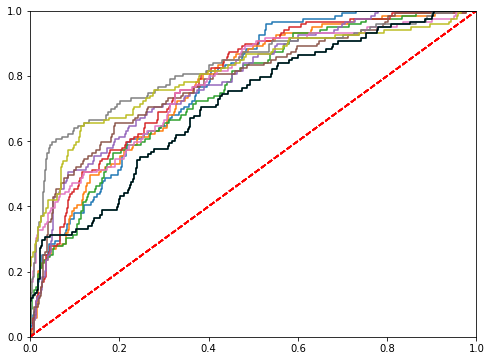

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Setup cross-validation and data structures to store results
nfold = 10
resultscv = list()
cv = StratifiedKFold(n_splits=nfold)
cv_auc_test = np.zeros(nfold)
cv_auc_test[cv_auc_test == 0] = 'nan' #for now, to avoid 0 values to be taken into account for, help ? average
cv_auc_train = np.zeros(nfold)
fpr_cv = {}
tpr_cv= {}
thresholds = {}

# Configure the plot we are about to create 
plt.figure(figsize=[8,6])
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])

print('Cross-validating the logit model:')
for i, (tr_idx, vl_idx) in enumerate(cv.split(X, y)):
    xtr, xvl = X.iloc[tr_idx], X.iloc[vl_idx]
    ytr, yvl = y[tr_idx], y[vl_idx]
    sk_logit.fit(xtr, ytr)
    temp = sk_logit.predict_proba(xvl)[:, 1]
    fp_rate_cv, tp_rate_cv, threshold = metrics.roc_curve(yvl, temp.astype('float'))
    thresholds[i] = threshold
    fpr_cv[i] = fp_rate_cv
    tpr_cv[i] = tp_rate_cv
    cv_auc_test[i] = metrics.auc(fp_rate_cv, tp_rate_cv)
    print('\tCV iter: {} with AUC={}'.format(i, cv_auc_test[i]))
    print('Average AUC on test set during cross-validation: {:.4f}'.format(np.nanmean(cv_auc_test)))
    
    # Print ROC curve
    plt.plot(fp_rate_cv,tp_rate_cv)
    plt.plot([0, 1], [0, 1], "r--")
    
    #save training performance for evaluation
    temp=sk_logit.predict_proba(xtr)[:, 1]
    fp_rate, tp_rate, _ = metrics.roc_curve(ytr, temp.astype('float'))
    cv_auc_train[i] = metrics.auc(fp_rate, tp_rate)


mean_fp_rate_cv = pd.DataFrame(np.vstack(fp_rate_cv))
mean_tp_rate_cv = pd.DataFrame(np.vstack(tp_rate_cv))

plt.plot(mean_fp_rate_cv, mean_tp_rate_cv, color='black')    
plt.show()

In [ ]:
auc_trace.update( {'logit_cv' : np.mean(cv_auc_test)})
print('Avg. auc = {:f}({:f})'.format(np.mean(cv_auc_test), np.std(cv_auc_test)))

Avg. auc = 0.778218(0.028599)


<a id="ch4"></a>

## 4. Regularized logistic regression and grid-search

Regularization is a method that aims to avoid overfitting. Complex models tend to show a high variance. Model complexity and bias are closely connected (low complexity -> high bias and vice versa). Introducing bias can help prevent overfitting, as it reduced variance. This is done by adding a complexity penalty. 

In a regression setting, large coefficients are indicators of complex, unstable models. Possible causes include high dimensionality and multicollinearity. The aim of the model is to minimize the magnitude the coefficients have on the model. Therefore, it is included in the loss function. 

$$ 𝜷←min⁡ℒ(𝜷)+𝜆||(𝜷)||{_1} $$

This penalty produces sparser models, as it forces the coefficients to zero. Furthermore, we also have a new meta-parameter $𝜆$ (equivalent to as 'C' in the code below), which requires tuning. Therefore, we use a grid search to identify its best setting. The higher $𝜆$ , the higher the penalty for complexity.

In [ ]:
# Trying to improve performance using regularized logit
lasso = LogisticRegression(penalty='l1', C=0.1, fit_intercept=True, max_iter=200, solver='liblinear')
lasso.fit(x_train, y_train)
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, lasso.predict_proba(x_test)[:, 1])
auc_trace.update( {'lasso' : metrics.auc(fp_rate, tp_rate)} )
print('Lasso test set AUC: {:.4f}'.format(auc_trace['lasso'] ))

Lasso test set AUC: 0.7936


#### Meta-parameter tuning

Meta-parameters are those that we have to choose before building a model, just as the complexity meta-parameter in the regularized logistic regression. Different learners exhibit different meta-parameters. Tuning (some of) these is often beneficial and grid-search is a versatile approach to do so. Grid-search specifies different values for each meta-parameter and evaluates all possible combinations of meta-parameters in the search grid. Let's try to improve the LASSO model by tuning its meta-parameter.

In [ ]:
# Try finding a better setting for penalty parameter C using grid search
from sklearn.model_selection import GridSearchCV

penalty_settings = {'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1]}
print('Grid-searching regularization parameter')
gs_lasso = GridSearchCV(lasso, penalty_settings, scoring='roc_auc', refit=True, cv=nfold)
gs_lasso.fit(x_train, y_train)

# Find test set auc of the best lasso model
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_lasso.predict_proba(x_test)[:, 1])
auc_trace.update( {'lasso_gs' : metrics.auc(fp_rate, tp_rate)} )
print('Lasso test set AUC with best paramter: {:.4f}'.format(auc_trace['lasso_gs']))

Grid-searching regularization parameter
Lasso test set AUC with best paramter: 0.7936


In [ ]:
# Which was the best penalty?
gs_lasso.best_params_

{'C': 0.3}

A nice feature of regularized linear models is that we can compute the **full regularization path**. This means we can examine the examine the magnitude of coefficient values across different settings of the penalty parameter. The larger the penalty the more emphasize is put on shrinking coefficients, and the less emphasize is put on minimizing the loss. The following codes, which are from the set of [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py), showcase how to produce a graph of the regularization path. This analysis is useful to inform our choice of penalty values for grid-search. However, for larger data sets, computing the regularization path is a costly exercise, possibly even more costly than running grid-search, so that a more plausible use case is to diagnose a model or to shed light on the independent variables. 

In [ ]:
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(x_train, y_train, fit_intercept=True)

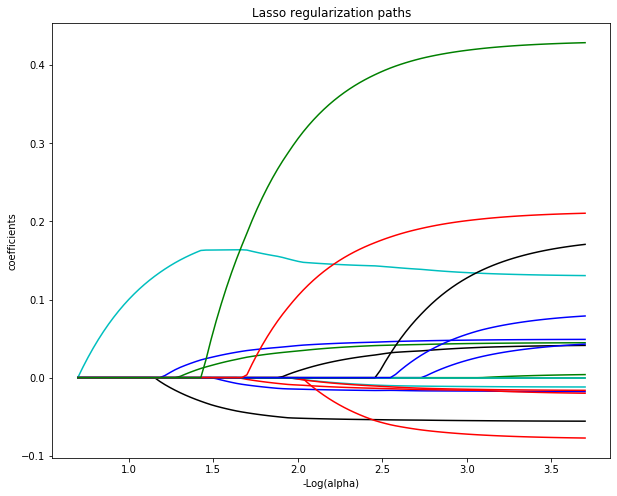

In [ ]:
# Display results based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
from itertools import cycle
colors = cycle(['b', 'r', 'g', 'c', 'k'])

plt.figure(figsize=[10,8])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso regularization paths')
plt.show();

<a id="ch5"></a>

## 5. Ensemble learning using Random Forest and XGB
Both regularized regression show a slight improvement in our predictions. But can we do more?

### Random Forest

The random forest algorithm is an ensemble algorithm. It uses many base models (decision trees) and predicts the target variable by averaging over their predictions. The base model trees are grown from bootstrap samples of the training set (random samples with replacement) and different random sample of attributes (random subspace). This means that instead of using all observations and features in our data, we build a variety of models on smaller subsets of both the data AND the attributes. This allows the algorithms to pick up on more rules, as it forces models to find rules only based on the given subset of attributes. This way we might discover rules that a normal model would overshadow. This happens when one attribute has a high impact on the outcome variable.

#### Meta-parameters in our grid search
Random forest is often considered robust toward meta-parameter settings. Still, some tuning may be beneficial. We consider the following meta-parameters. 
<br>
- n_estimators: number of trees(models) in forest (ensemble)<br>
- max_features : maximum features in random subspace<br>

There are a couple of more meta-parameters. Normally, you would not need to tune them but for the sake of completeness, here are some more meta-parameters:
- min_samples_split: minimum number of samples required in leaf node before another split is made. If it is less, this node won't split.<br>
- min_samples_leaf: minimum number of samples required to be at a leaf node.<br>
- max_leaf_nodes: maximum number of leaf nodes in a tree<br>
- criterion: splitting function to use, e.g. gini coefficient<br>
- max_depth: pruning parameter, maximum depth of decision tree<br>
- n_jobs: parallelization of model building<br>
- random_state: this parameter is used to define the random selection. It is used for comparison between various models.<br><br>

If meta-parameters are not specified, they will be set to their default. 

**Remark**: Tuning RF might take a while. If you want to speed things up, consider setting the meta-parameter *max_samples*. It allows you to control the size of the bootstrap sample from which each tree is grown. Read the documentation for more information. Smaller sample sizes accelerate the training.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Performance of tree-based ensemble algorithms in the form of random forest

print('Tuning random forest classifier')
rf = RandomForestClassifier(random_state=123, max_samples = 0.5)  # This way, bootstrap sample size will be 50% of the training set

# Define meta-parameter grid of candidate settings
# The following settings are just for illustration
param_grid = {'n_estimators': [100, 200, 500],
              'max_features': [1, 2, 4]
              }

# Set up the grid object specifying the tuning options
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_rf.fit(x_train, y_train)

In [ ]:
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)

# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_rf.predict_proba(x_test)[:, 1])
auc_trace.update( {'rf' : metrics.auc(fp_rate, tp_rate)}) 
print('RF test set AUC: {:.4f}'.format(auc_trace['rf']))

Best CV AUC: 0.9754
Optimal RF meta-parameters:
{'max_features': 1, 'n_estimators': 500}
RF test set AUC: 0.9984


You should see some quite impressive AUC value. Let's plot the ROC curve to appreciate the power of our RF. This also shows how to access the final model from the grid-search results.

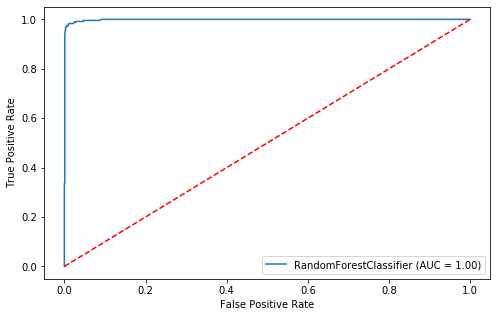

In [ ]:
# The plot is not new but note the use of gs_rf.best_estimator_ 
metrics.plot_roc_curve(gs_rf.best_estimator_, x_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

### XGBoost


XGB (Extreme Gradient Boosting) is a state-of-the-art algorithm. It builds an ensemble iteratively by fitting weak learners (typically shallow trees) to correct the errors of the current models. Error correction is implemented via gradient descent. As such, the learning rate is one out of several meta-parameters we need to consider when building an XGB classifier.

Note that different implementations of XGB are available in Python. We demonstrate XGB using the *xgboost* library, which is very popular. Using the scikit-learn version is simpler but might not incorporate all the features of XGB. 

In [ ]:
import xgboost as xgb
    # Setting up the grid of meta-parameters
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.5, 0.9, 5),  # random subspace
    'n_estimators': [100, 200],  # ensemble size or number of gradient steps
    'max_depth': [5, 10],   # max depth of decision trees
    'learning_rate': [0.1, 0.01],  # learning rate
    'early_stopping_rounds': [10]}  # early stopping if no improvement after that many iterations

gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=1)
gs_xgb.fit(x_train, y_train)

In [ ]:
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)

# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_xgb.predict_proba(x_test)[:, 1])
auc_trace.update( {'xgb' : metrics.auc(fp_rate, tp_rate)})
print('XGB test set AUC with optimal meta-parameters: {:.4f}'.format( auc_trace['xgb'] ))

Best CV AUC: 0.9495
Optimal XGB meta-parameters:
{'colsample_bytree': 0.5, 'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGB test set AUC with optimal meta-parameters: 0.9962


The XGB models completes our journey through the space of learning algorithms. We have covered the maybe most important learners; of course albeit neural networks, which will be our focus in the next coding session. Let's have a final look at the AUC results we obtained:

In [ ]:
auc_trace

{'logit': 0.792583205495898,
 'logit_cv': 0.7782178552654251,
 'lasso': 0.793628137575313,
 'lasso_gs': 0.793623691055826,
 'rf': 0.9983948064652394,
 'xgb': 0.9962160119166722}

The AUC results justify two conclusions. First, the data exhibits a strong signal. This follows from the overall high level of AUC performance. The remarkable differences between linear and nonlinear classifiers further suggests that the feature-response relationship is nonlinear. To shed some light on this relationship, the last part of the tutorial revisits two popular approaches in the scope of interpretable machine learning, permutation-based feature importance and partial dependence. I have included these examples in this notebook because they connect directly to the previous steps. However, please note that you will learn about the techniques that we use only later, in Block III of the ML course. For now, just note that this notebook has some more examples waiting for you, and come back after completing lecture L.III.1 on Interpretable Machine Learning.

<a id="ch6"></a>

## 6. Feature importance analysis and model diagnosis

The interpretability of machine learning models is a big topic, because usually, the more complicated the model, the harder it will be to understand how our final predictions are computed. Especially for so called black-box models, methods have been develop to understand the importance of specific features in these models. 

### Permutation-based feature importance

Permutation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. In order to do this, we permute one variable by shuffling its values across all observations. This means, each observation will receive a new value. This permutation breaks the relationship to the target variable. Then we make an assumption: the higher the increase of the error due to the permutation, the more important this variable was in building the model. This way we can compute a ranking. 

Let's give it a try using our Random Forest model.

In [ ]:
plt.rcParams['figure.figsize'] = 20, 10

# Permutation-based feature importance
print('Computing permutation-based feature importance...')
from sklearn.inspection import permutation_importance

classifier = gs_rf.best_estimator_

perm_imp = permutation_importance(classifier, x_test, y_test, scoring='roc_auc', random_state=123)
sorted_idx = perm_imp.importances_mean.argsort()

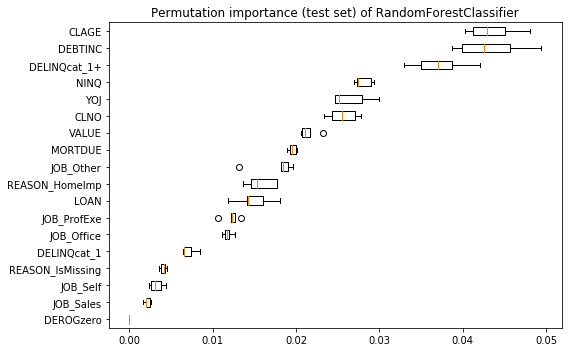

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation importance (test set) of {}".format(str(classifier)[0:str(classifier).find('(')]))
fig.tight_layout()
plt.show()

The result agrees with domain knowledge. The debt-to-income ratio proves very important. RF devotes much attention to this feature so that permuting it increases the prediction error. High importance of the number of delinquent credit lines (DELINQ) also makes sense. For CLAGE, the age of the oldest credit line in months it is maybe less obvious how it affects the target. Specifically, it would be useful to check whether high/lower values in this feature are associated with higher/lower default probability. We do not get such insight from permutation-based feature importance analysis. But partial-dependence should give as an answer.

### Partial dependence plot (PDP)
A PDP shows what type of effect a feature has on predicted probabilities. A PDP plots the values of a chosen variable (on the x-axis) against model-estimated probabilities (on the y-axis) whilst according for the combined effect of all other features. 

Computing partial dependence plots...


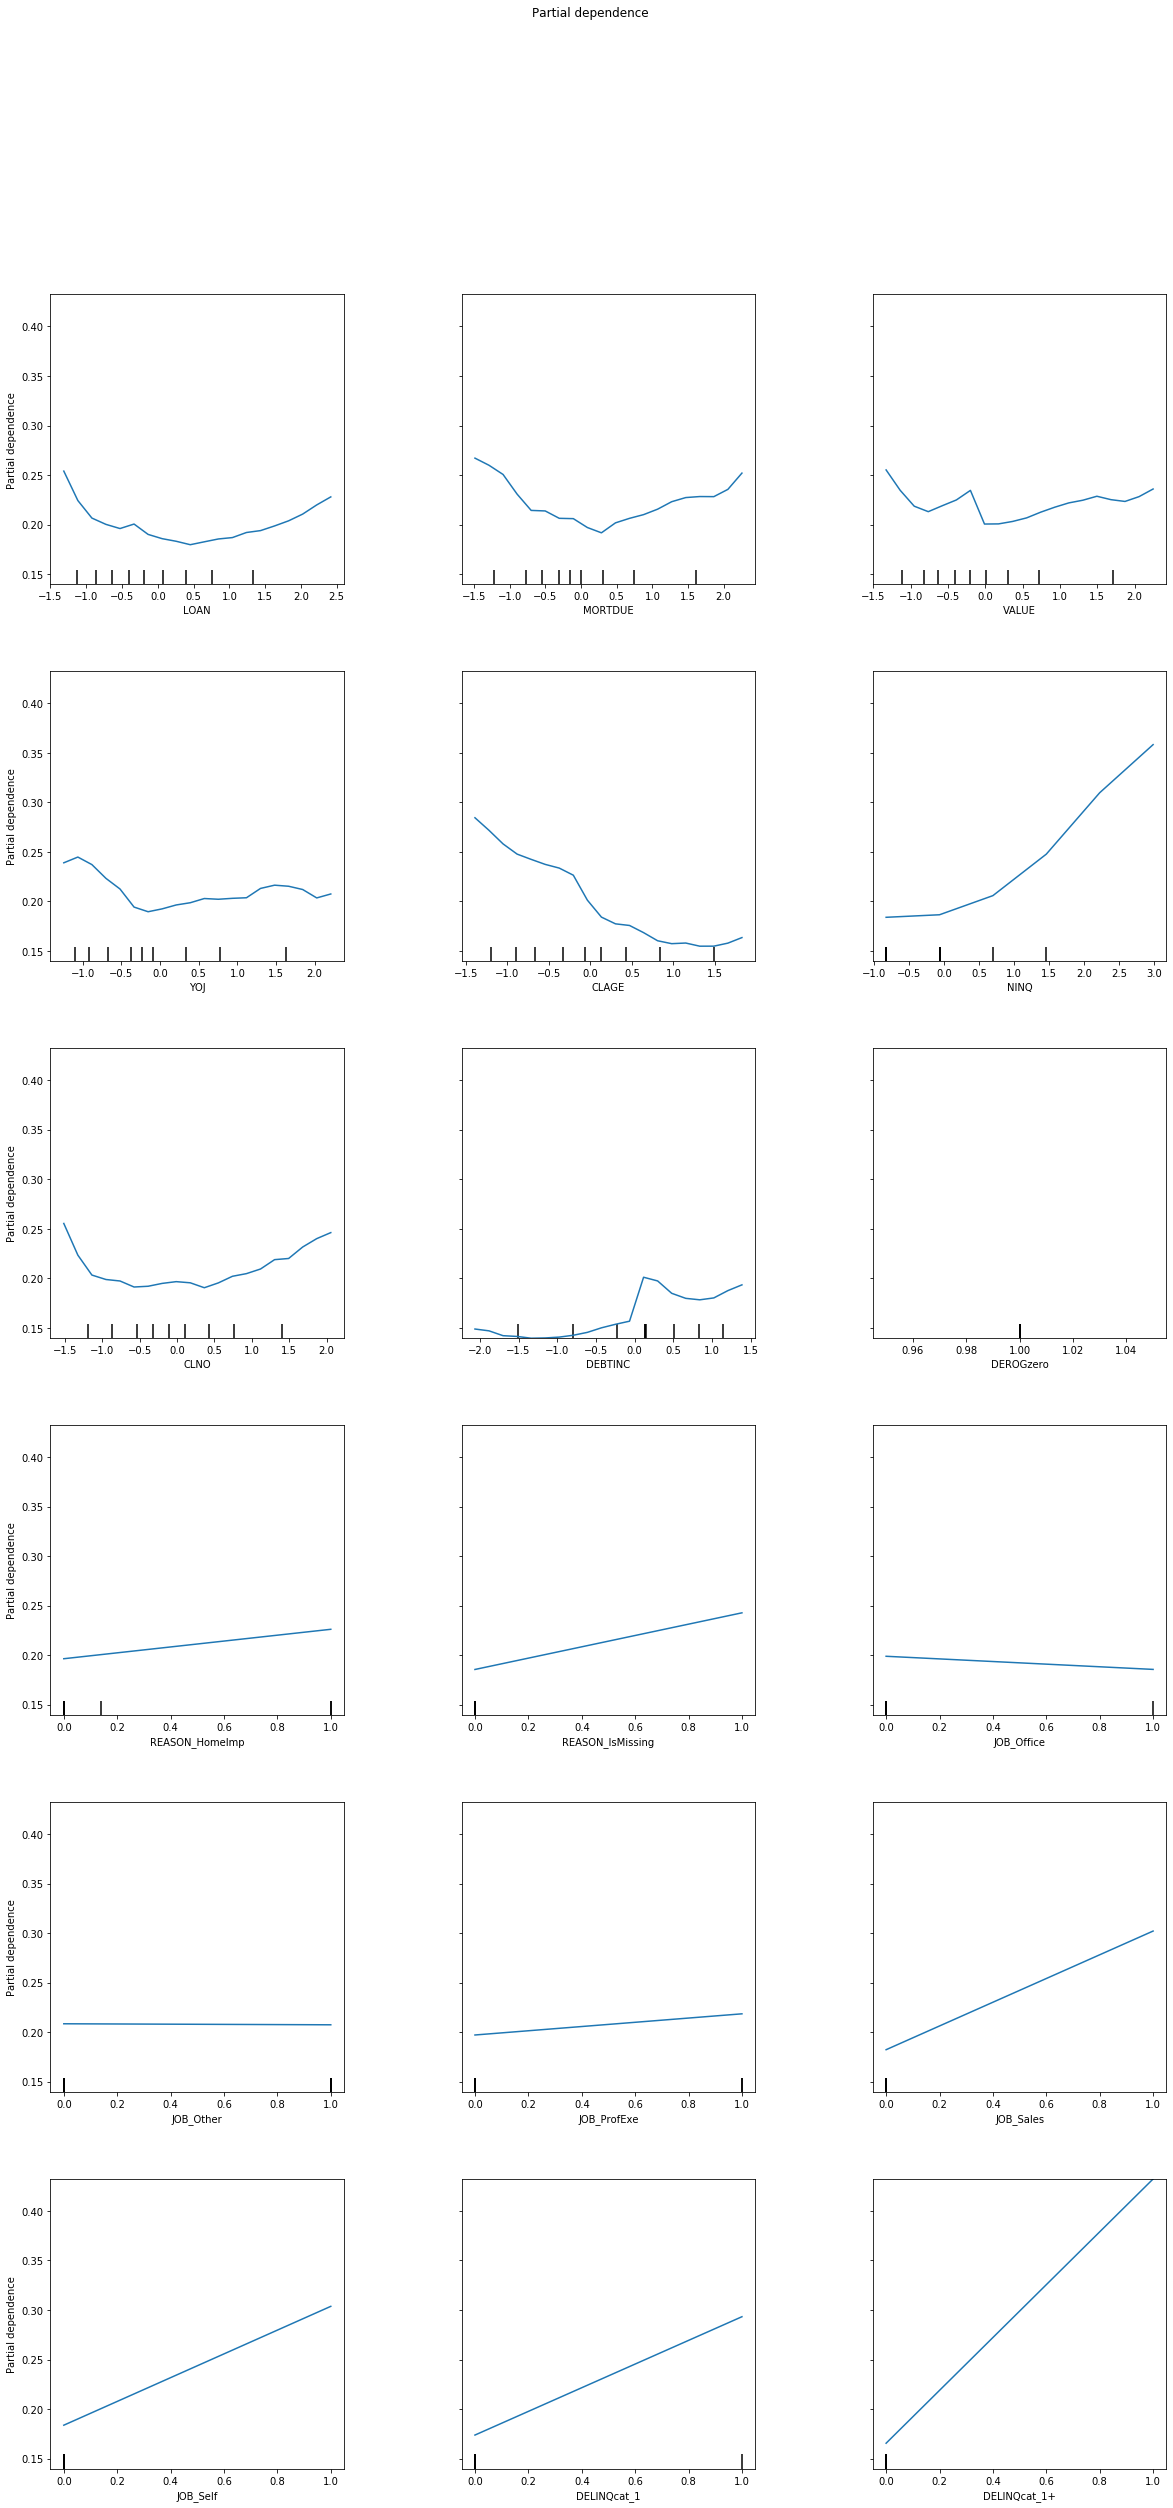

In [ ]:
plt.rcParams['figure.figsize'] = 20,40
# Partial dependence
from sklearn.inspection import plot_partial_dependence
classifier = gs_rf.best_estimator_
print('Computing partial dependence plots...')
features = x_train.columns

plot_partial_dependence(classifier, x_train, features, n_jobs=3, grid_resolution=20)

fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

Coming back to the question how CLAGE affects the PD estimates, we now have a clear answer. Higher values decrease PDs. That makes sense because high values indicate that a client has been with the bank for a longer time. We would expect such customers to be less likely to default compared to newer customers. 

As a cautionary remark, always make sure to know what exactly the y-axis is showing, the probability of being a good or a bad customer. In a binary classification setting, scikit-learn considers the class with the higher value the positive class.